# ***Set parameters***

In [1]:
__algo__ = "MBKMEANS"              #Name of the Clustering algorithm
__emb__ = "glove"                #Name of the Word Embeddings used (glove, w2v, ftt), MUST set directory below
__sentemb__ = "pmeans5"          #Name of Sentence Embedding algorithm used
recnum = 3000                     #Number of records to be read from files
k = 50                            #Number of Clusters
usesqrt = False                   #Set value of k to sqrt of recnum, overrides k
randomsample = False              #Random Sampling to be True/False for records which are read
embedDir = "../MegaSentEmbs/"     #Directory where embeddings are saved for that selected embedding
modelDir = "../models/"           #Directory where models are saved
megadfDir = "../MegaDfs/"         #Directory Where Megadf is to be saved
plotDir = "../plots/"             #Directory where plots are saved
metadataDir = "../modelMetaData/" #Directory where performance and distribution params are to be stored
dumpDir = "../dump/"              #Directory where test outcomes are saved

# Actual Code

### imports and time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import os, subprocess, sys
import datetime, time
import pickle

### File Settings

In [3]:
oldlist = os.listdir(embedDir)
filelist = sorted([embedDir+f for f in oldlist if f[-3:]=="pkl"])
filenum = len(filelist)
smalllist = filelist[:filenum]
print("Length of Smalllist: ", len(smalllist))

Length of Smalllist:  116


### Number of Records
It is Recommended to Set this at the top parameters

In [4]:
recnum = recnum

### Read all the pandas dataframes

In [5]:
%%time
megadf = pd.DataFrame()

if randomsample == True:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
    megadf = megadf.sample(recnum, random_state=42)
else:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
        if megadf.shape[0] >= recnum:
            megadf = megadf[:recnum]
            break

print("megadf.shape: ", megadf.shape)

randomsample:  False
megadf.shape:  (3000, 4)
CPU times: user 113 ms, sys: 24.2 ms, total: 137 ms
Wall time: 136 ms


In [6]:
predata = megadf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(3000, 250)


### Number of Clusters
It is Recommended to Set this at the top parameters

In [7]:
if usesqrt == True:
    print("usesqrt: ", usesqrt)
    sqrt_k = int(np.sqrt(data.shape[0]))
    k = int(sqrt_k)
else:
    print("usesqrt: ", usesqrt)
    k = k
print("k: ", k)

usesqrt:  False
k:  50


## Clustering
Please modify the functions here to change algorithm

In [8]:
%%time
print("Starting Clustering Process")
start_time = time.time()
model = cluster.MiniBatchKMeans(n_clusters=k, n_init = 20, random_state=42, batch_size=32, max_iter=1000, verbose=1)
model.fit(data)
end_time = time.time()
timetrain = round(end_time-start_time, 2)
print("done! {}".format(timetrain))
print("k_means.fit(data) Done!")

Starting Clustering Process
Init 1/20 with method: k-means++
Inertia for init 1/20: 738.999521
Init 2/20 with method: k-means++
Inertia for init 2/20: 735.832880
Init 3/20 with method: k-means++
Inertia for init 3/20: 739.443053
Init 4/20 with method: k-means++
Inertia for init 4/20: 769.243647
Init 5/20 with method: k-means++
Inertia for init 5/20: 791.191852
Init 6/20 with method: k-means++
Inertia for init 6/20: 766.260956
Init 7/20 with method: k-means++
Inertia for init 7/20: 779.850767
Init 8/20 with method: k-means++
Inertia for init 8/20: 752.456362
Init 9/20 with method: k-means++
Inertia for init 9/20: 724.018322
Init 10/20 with method: k-means++
Inertia for init 10/20: 729.552848
Init 11/20 with method: k-means++
Inertia for init 11/20: 705.096331
Init 12/20 with method: k-means++
Inertia for init 12/20: 858.352089
Init 13/20 with method: k-means++
Inertia for init 13/20: 791.600468
Init 14/20 with method: k-means++
Inertia for init 14/20: 750.328489
Init 15/20 with method: 

Minibatch iteration 90/94000: mean batch inertia: 12.635331, ewa inertia: 12.314598 
Minibatch iteration 91/94000: mean batch inertia: 12.286492, ewa inertia: 12.313998 
Minibatch iteration 92/94000: mean batch inertia: 11.965055, ewa inertia: 12.306557 
Minibatch iteration 93/94000: mean batch inertia: 11.669826, ewa inertia: 12.292977 
Minibatch iteration 94/94000: mean batch inertia: 11.376755, ewa inertia: 12.273438 
Minibatch iteration 95/94000: mean batch inertia: 12.118874, ewa inertia: 12.270142 
Minibatch iteration 96/94000: mean batch inertia: 10.915531, ewa inertia: 12.241253 
Minibatch iteration 97/94000: mean batch inertia: 12.202469, ewa inertia: 12.240426 
Minibatch iteration 98/94000: mean batch inertia: 12.616460, ewa inertia: 12.248445 
Minibatch iteration 99/94000: mean batch inertia: 12.099136, ewa inertia: 12.245261 
Minibatch iteration 100/94000: mean batch inertia: 10.828674, ewa inertia: 12.215051 
Minibatch iteration 101/94000: mean batch inertia: 11.211434, ew

done! 0.82
k_means.fit(data) Done!
CPU times: user 1.58 s, sys: 15 ms, total: 1.59 s
Wall time: 817 ms


### Saving the output data into vars

In [9]:
centroids = model.cluster_centers_
labels = model.labels_
megadf["clusterlabel"]=labels
centroidDF = pd.DataFrame(centroids)


## Plotting

Text(0.5, 1.0, 'MBKMEANS with k=50 records=3000 features=250 using glove')

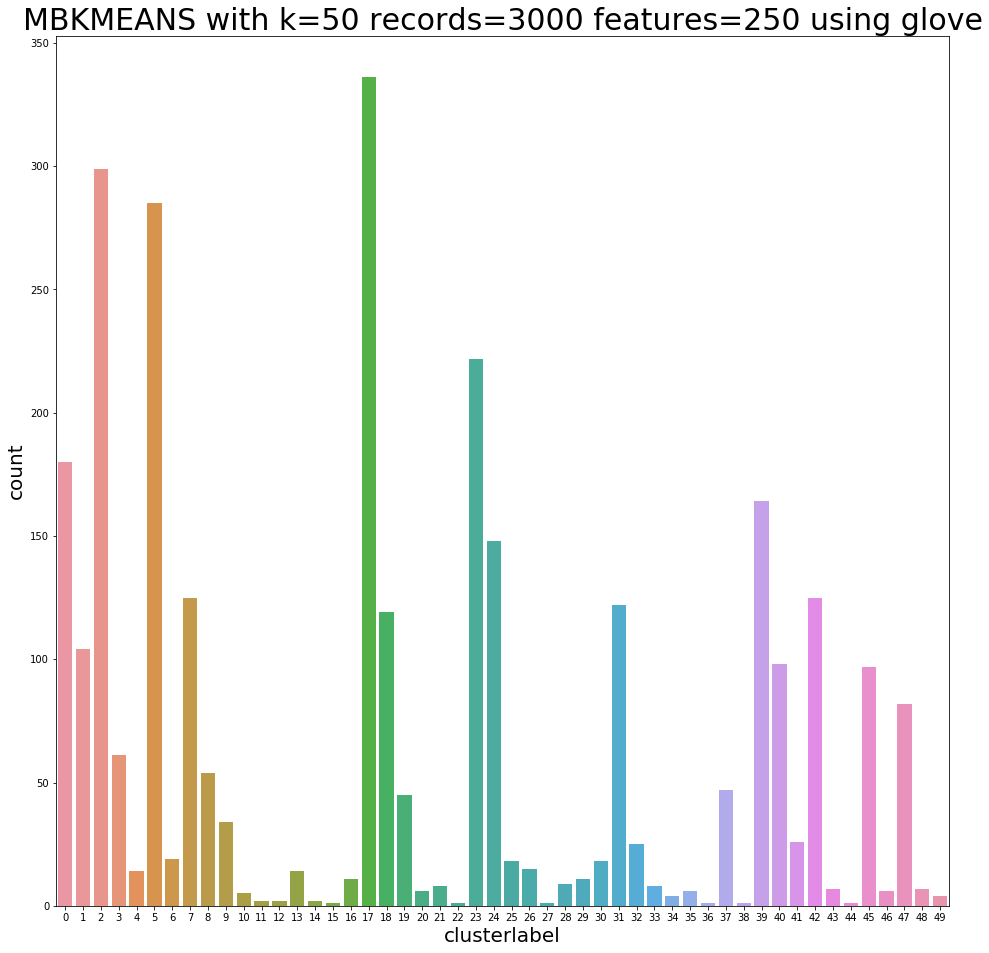

In [10]:
plt.figure(figsize=(16,16))
titlestring = "{} with k={} records={} features={} using {}".format(__algo__, k, data.shape[0], data.shape[1], __emb__)
snsplot = sns.countplot("clusterlabel", data=megadf)
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 30}
    )

### *Name given to saved files*

In [11]:
features = data.shape[1]
records = data.shape[0]
name = "{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, records, features)
name

'MBKMEANS_glove_pmeans5_K50_R3000_F250'

### Saving Data

Save model

In [12]:
modelname = "{}_model.pkl".format(name)
pickle.dump(model, open(modelDir + modelname, 'wb'))

Save Plot

In [13]:
snspltname = "{}_plt.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

Save Megadf

In [14]:
clusterdfname = "{}_clustered_megadf.pkl".format(name)
megadf.to_pickle(megadfDir + clusterdfname)

Save Centroids

In [15]:
centroidDF = pd.DataFrame(centroids)
centroidDFname = "{}_centroids.pkl".format(name)
centroidDF.to_pickle(megadfDir + centroidDFname)
print(centroidDF.shape)

(50, 250)


#### Open dataframe to test

In [16]:
sub = megadf.loc[:, ["id", "title", "abstract", "clusterlabel"]]
sub.tail()

,id,title,abstract,clusterlabel
2995,1588822,Defining the clinical role of the mammalian ta...,"[lung, cancer, biggest, cancer, killer, patien...",0
2996,1588823,Bio-functionalised nanoparticles for enzyme se...,"[inorganic, nanoparticles, accompanying, diver...",0
2997,1588824,Lithological mapping on the Antarctic Peninsul...,"[antarctic, peninsula, larger, uk, limited, ge...",17
2998,1588825,"WWOX, tumour suppressor and modifier gene, as ...","[wwox, tumour, suppressor, gene, demonstrated,...",0
2999,1588826,Improving efficiency in drive lines : an exper...,"[research, concern, improvement, power, effici...",17


In [17]:
megadf.columns

Index(['id', 'title', 'abstract', 'embedding', 'clusterlabel'], dtype='object')

# Performance Testing and Distribution


In [18]:
metadata = pd.DataFrame(columns=["Name", "Algo", "WordEmb", "SentEmb", "K", "R", "F", "SS", "CSavg", "CSmin", "CSmax", "T2Pavg", "T2LM", "T2LMP", "MEM"])

In [19]:
metadict = {
    "Name":None,                     #Name of the save file prefix
    "Algo":None,                     #Name of the Clustering algorithm
    "WordEmb":None,                  #Name of the Word Embeddings used (glove, w2v, ftt)
    "SentEmb":None,                  #Name of Sentence Embedding algorithm used 
    "K":None, "R":None, "F":None,    #Number of clusters, records and fetures
    "T2T":None,                      #Time required to train model
    "SS":None,                       #Silhoutte Score
    "DBS":None,                      #Davis Bouldin Score
    "CSavg":None,                    #Average Cluster Size
    "CSmin":None,                    #Minimum Cluster Size
    "CSmax":None,                    #Maximum Cluster Size
    "T2Pavg":None,                   #Average Time To Predict cluster of one record
    "T2LM":None,                     #Average Time to Load Model
    "T2LMP":None,                    #Amortized time to Predict after loading the model
    "MEM":None                      #Memory used by the Model
    }
metadict

{'Name': None,
 'Algo': None,
 'WordEmb': None,
 'SentEmb': None,
 'K': None,
 'R': None,
 'F': None,
 'T2T': None,
 'SS': None,
 'DBS': None,
 'CSavg': None,
 'CSmin': None,
 'CSmax': None,
 'T2Pavg': None,
 'T2LM': None,
 'T2LMP': None,
 'MEM': None}

In [20]:
metadict["Name"]=name
metadict["Algo"]=__algo__
metadict["WordEmb"]=__emb__
metadict["SentEmb"]=__sentemb__
metadict["K"]=k
metadict["R"]=recnum
metadict["F"]=features
metadict

{'Name': 'MBKMEANS_glove_pmeans5_K50_R3000_F250',
 'Algo': 'MBKMEANS',
 'WordEmb': 'glove',
 'SentEmb': 'pmeans5',
 'K': 50,
 'R': 3000,
 'F': 250,
 'T2T': None,
 'SS': None,
 'DBS': None,
 'CSavg': None,
 'CSmin': None,
 'CSmax': None,
 'T2Pavg': None,
 'T2LM': None,
 'T2LMP': None,
 'MEM': None}

#### Time to train

In [21]:
metadict["T2T"]=timetrain

#### Scores

In [22]:
ss = silhouette_score(data, labels, metric = 'euclidean')
dbs = davies_bouldin_score(data, labels)
metadict["SS"]=ss
metadict["DBS"]=dbs

#### Cluster Size

In [23]:
clusterdata = megadf.groupby("clusterlabel", as_index=True).size().reset_index(name="count")
clusterdata.head()

,clusterlabel,count
0,0,180
1,1,104
2,2,299
3,3,61
4,4,14


In [24]:
clusterdfname = "{}_clustered_counts.pkl".format(name)
clusterdata.to_pickle(megadfDir + clusterdfname)

In [25]:
countdata = clusterdata.groupby("count").size().reset_index(name="clusters")
display(countdata.head(3))
display(countdata.tail(3))

,count,clusters
0,1,6
1,2,3
2,4,2


,count,clusters
31,285,1
32,299,1
33,336,1


In [26]:
metadict["CSmax"] = max(clusterdata["count"])
metadict["CSmin"] = min(clusterdata["count"])
metadict["CSavg"] = np.mean(clusterdata["count"])

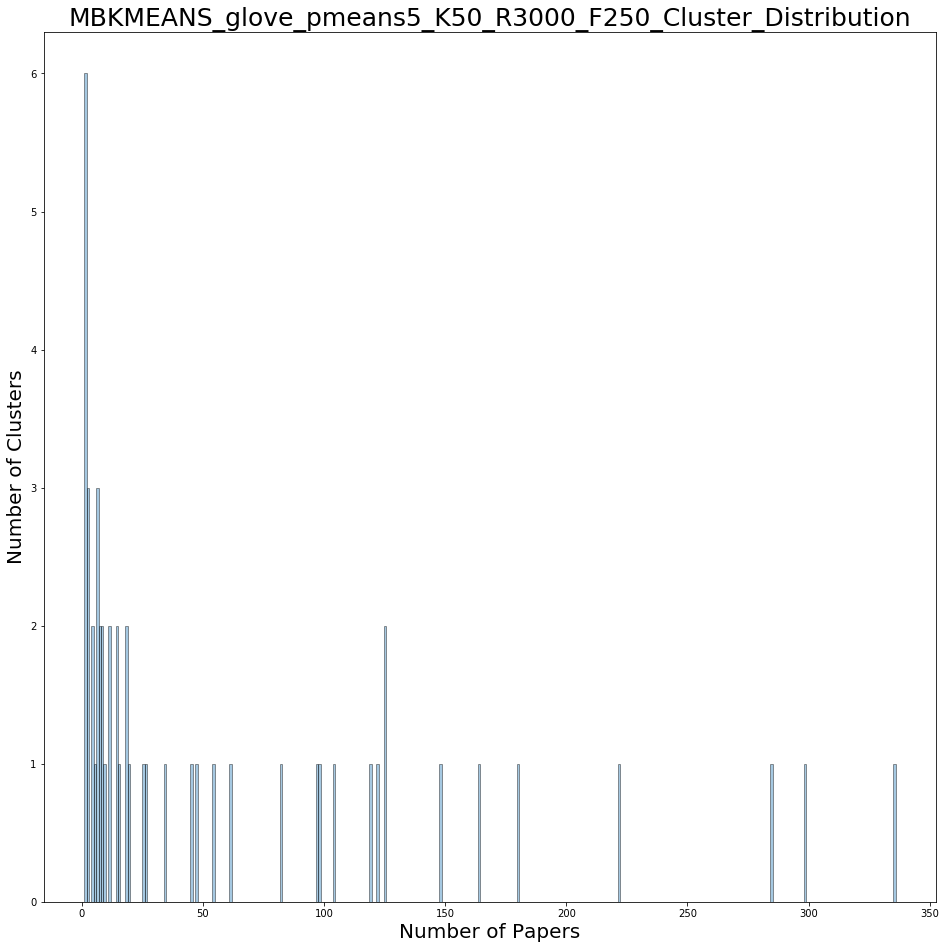

In [27]:
%matplotlib inline
plt.figure(figsize=(16,16))

sns.axes_style("whitegrid", {"axes.grid":True, 
                            'axes.spines.left': False,
                             'axes.spines.bottom': False,
                             'axes.spines.right': False,
                             'axes.spines.top': False})


titlestring = "{}_Cluster_Distribution".format(name)
snsplot = sns.distplot(clusterdata["count"], kde=False, bins=max(clusterdata["count"]),
                      hist_kws={'edgecolor':'black'},)
snsplot.set(xlabel="Number of Papers", ylabel="Number of Clusters")
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 25}
    )
plt.show()



In [28]:
snspltname = "{}_Cluster_Distribution.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)

#### Prediction Time Performance

In [29]:
testdf = pd.DataFrame()
if recnum < 2000:
    samplenum = int(recnum / 10)
else:
    samplenum = 2000

for f in smalllist:
    tempdf = pd.read_pickle(f)
    testdf = megadf.append(tempdf, ignore_index = True, sort = False)
testdf = testdf.sample(samplenum, random_state=int(time.time()%100000))
predata = testdf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(2000, 250)


In [30]:
print("Starting Predicting Performance")
testmodel = model
start_time = time.time()
for d in data:
    lb = testmodel.predict(d)
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/data.shape[0]
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2Pavg"]=avgtime

Starting Predicting Performance
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignm

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

In [31]:
print("Starting Loading Performance")
loadruns = 50
start_time = time.time()
for i in range(loadruns):
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/loadruns
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LM"] = avgtime
avgtime

Starting Loading Performance
Avgtime: 0.0006687021255493164 Totaltime: 0.03343510627746582


0.0006687021255493164

In [32]:
print("Starting Amortized Performance")
loadruns = 5
avglist = []

for i in range(loadruns):
    start_time = time.time()
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
    for d in data:
        lb = testmodel.predict(d)
    end_time = time.time()
    timetest = (end_time-start_time)/data.shape[0]
    avglist.append(timetest)

timetest = np.sum(avglist)
avgtime = np.mean(avglist)
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LMP"] = avgtime
avgtime

Starting Amortized Performance
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignme

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

0.0007053296089172364

In [33]:
modelsize = sys.getsizeof(pickle.dumps(model))
print("modelsize:", modelsize, "bytes")
metadict["MEM"]=modelsize

modelsize: 113296 bytes


In [34]:
metadict

{'Name': 'MBKMEANS_glove_pmeans5_K50_R3000_F250',
 'Algo': 'MBKMEANS',
 'WordEmb': 'glove',
 'SentEmb': 'pmeans5',
 'K': 50,
 'R': 3000,
 'F': 250,
 'T2T': 0.82,
 'SS': -0.029269573405809525,
 'DBS': 2.4350618105516832,
 'CSavg': 60.0,
 'CSmin': 1,
 'CSmax': 336,
 'T2Pavg': 0.0006249277591705323,
 'T2LM': 0.0006687021255493164,
 'T2LMP': 0.0007053296089172364,
 'MEM': 113296}

In [35]:
metadata = metadata.append(metadict, ignore_index=True)
metadata

,Name,Algo,WordEmb,SentEmb,K,R,F,SS,CSavg,CSmin,CSmax,T2Pavg,T2LM,T2LMP,MEM,DBS,T2T
0,MBKMEANS_glove_pmeans5_K50_R3000_F250,MBKMEANS,glove,pmeans5,50,3000,250,-0.02927,60.0,1,336,0.000625,0.000669,0.000705,113296,2.435062,0.82


In [36]:
metadataname = "{}_metadata.pkl".format(name)
metadata.to_pickle(metadataDir + metadataname)